# Create Simulated Data Set from Kinetic Model
This notebook currently creates a simulated limonene data set for use in the KineticLearning.ipynb file.  This file can be time consuming to run.

## 1. Setup & Import
Set Parameters for Creation of Simulated DataSet

In [1]:
# Set Parameters
kinetic_name = 'Full'          # Choose Kinetic Model To Generate Data For
numStrains = 10000               # Number of Strains to Generate
use_kinetic_model_fit = False  # Use the Fit Values for the Kinetic Data as starting parameters

# Set Output Time Points
timePoints = [0,2,4,6,8,10,12,14,16,18,20,24,28,32,36,40,44,48]
timePoints = list(range(70))

# measurement_noise_percent = 0.00005
# sigma = measurement_noise_percent**(0.5)

Import Required Modules

In [2]:
import csv
import math
import numpy as np
from scipy.integrate import odeint,ode

#Ploting Utilities
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display

Define Helper Functions

In [3]:
def odeintz(fun,y0,times):
    maxDelta = 10
    
    f = lambda t,x: fun(x,t)
    r = ode(f).set_integrator('dop853',nsteps=1000,atol=1e-6)
    r.set_initial_value(y0,times[0])

    #progress bar
    #f = FloatProgress(min=0, max=max(times))
    #display(f)

    
    #Perform Integration
    x = [y0,]
    curTime = times[0]
    for nextTime in times[1:]:
        #while r.successful() and r.t < nextTime:
        while r.t < nextTime:
            if nextTime-curTime < maxDelta:
                dt = nextTime-curTime
            else:
                dt = maxDelta
                
            value = r.integrate(r.t + dt)
            curTime = r.t
            #print(curTime, end='\r')
            #sleep(0.001)
            f.value = curTime
        x.append(value)
    return x

In [4]:
#Create Differential Equation
def kineticOde(x,t,k):
    def f(e1,e2,e3,e4,e5,e6,e7,e8,e9,
               s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,
               k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35,
               k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65,
               k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3):
        r1 = Vin - (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
        r2 = (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
        r3 = k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2) - k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35)
        r4 = k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35) - k41*e4*s4 / (k42*s9 + k43*s5 + k44*s4 + k45)
        r5 = k41*e4*s4 / (k42*s9 + k43*s5 + k44*s4 + k45) - k51*e5*s5 / (k52 + s5)
        r6 = k51*e5*s5 / (k52 + s5) - k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65)
        r7 = k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65) - k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
        r8 = k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
        r9 = k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8) - k91*e9*s9 / (k92 + s9)
        r10 = k91*e9*s9 / (k92 + s9)
        return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
    
    #print('len of param vec',len(k))
    #print('KineticCoefficients',k[3*9:],len(k[3*9:]))
    #print('Proteomics',k[:3*9],len(k[:3*9]))
    ke = k[:3*9]
    kr = k[3*9:]
    e = proteomicsData(t,ke)
    #print(len(e),len(x),len(kr))
    return f(*e,*x,*kr)

def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9,
               s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,
               k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35,
               k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65,
               k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3):
    r1 = Vin - (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
    r2 = (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
    r3 = k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2) - k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35)
    r4 = k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35) - k41*e4*s4 / (k42*s9 + k43*s5 + k44*s4 + k45)
    r5 = k41*e4*s4 / (k42*s9 + k43*s5 + k44*s4 + k45) - k51*e5*s5 / (k52 + s5)
    r6 = k51*e5*s5 / (k52 + s5) - k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65)
    r7 = k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65) - k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
    r8 = k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
    r9 = k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8) - k91*e9*s9 / (k92 + s9)
    r10 = k91*e9*s9 / (k92 + s9)
    return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

def simple_kinetics(x,t,k):
    #Parameters
    def f(e,s,k):
        e0,e1 = e
        s0,s1,s2 = s
        v_in,v_out,K_cat,K_s,K_i,K_cat1,K_m = k
        
        v_0 = K_cat*e0*(s0/K_s)/(1 + (s0/K_s) + (s2/K_i))
        v_1 = K_cat1*e1*s1/(K_m)
        r1 = v_in - v_0
        r2 = v_0 - v_1
        r3 = v_1 - v_in*s2
        return [r1,r2,r3]
    e = proteomicsData(t,k[0:6])
    return f(e,x,k[6:])
    
def proteomicsData(t,k):
    e = []
    for i in range(int(len(k)/3)):
        #Sorting the gains to ensure proteins only increase
        #gains = sorted(k[3*i:3*(i+1)],reverse=True)
        gains = k[3*i:3*(i+1)]
        e.append(leaky_hill_fcn(t,*gains)) 
    return e

def leaky_hill_fcn(t,kf,km,kl):
        return kf*t/(km + t) + kl

def applyMeasurementNoise(data,noise):
    return [[value + np.random.normal(scale=(noise*value)**(0.5)) for value in line] for line in data]

## 2. Extract Protein Time Series Curves From Real Data and Fit to Hill Function

In [5]:
if kinetic_name == 'Small':
    kinetic_fcn = simple_kinetics
    proteins = 2
    parameters = 7
    substrates = 3
    
    #CSV Header
    CSV = [['Strain','Time','e0','e1','s0','s1','s2']]

elif kinetic_name == 'Full':
    kinetic_fcn = kineticOde
    proteins = 9
    substrates = 10
    parameters = 34
    
    #CSV Header
    CSV = [['Strain','Time','AtoB','HMGS','HMGR','MK','PMK','PMD','Idi','GPPS','LS',
            'Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA','Mev','MevP','MevPP','IPP','DMAPP','GPP','Limonene']]

A Few bits of code to help understand the parameters...

**Kinetic Fit:**
[  5.27715270e+08   4.27024131e+02   5.23121317e+08   3.49139373e+08
   1.53108505e+03   5.01679469e+01   6.65986265e+08   9.96515901e+08
   1.65236177e+01   2.87429118e+08   4.59767573e+08   1.00320436e+08
   2.55724875e+08   6.32539506e+06   7.12783803e+08   9.60680172e+07
   4.13852542e+08   3.18329880e+04   5.52989871e+08   2.47237593e+08
   7.17889114e+08   7.50755996e+08   1.00000000e-12   6.48850195e+08
   1.42191830e+01   3.33891377e+08   5.85448828e+08   4.55254785e+08
   1.01295189e+08   2.76330022e+08   6.90161521e+08   4.98233858e+02
   8.63101820e+07   9.65536186e+08   8.07997571e+08   1.06576294e-04
   6.27655014e+08   2.28120610e-02   2.91790555e-01]

In [6]:
def cost_fcn(free_params):
    cost = 0
    for x_val,y_vals in zip(X,y):
        params = []
        params.extend(x_val[0:6])       # AtoB to PMD Values
        params.extend(free_params[0:2]) # Keep Constant GPPS and IDI levels as free parameters
        params.extend(x_val[6:8])       # LS and Acetyl-CoA
        params.append(free_params[2])   # AcetoAcetyl-CoA as a free Param
        params.extend(x_val[8:11])      # HMG-CoA & Mev & MevP measured
        params.append(free_params[3])   #MevPP 
        params.extend([x_val[11],x_val[11]]) #DMAPP & IDI Measured
        params.extend([free_params[4],x_val[12]]) #GPP as a Free Parameter #Measured Limonene Synthase
        params.extend(free_params[5:])  # Remaining Kinetic Free Parameters

        mp = kinetic_model(*params)
        prediction = [mp[0],mp[2],mp[3],mp[4],mp[6]+mp[7],mp[9]]
        cost += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
    return cost
        
#Figure out what Fit Value is associated with what kinetic model parameter Parameter
#kinetic_fit = [5.27715270e+08, # GPPS Enzyme
#               4.27024131e+02, # IDI Enzyme
#               5.23121317e+08, # AcetoAcetyl-CoA
#               3.49139373e+08, # MevPP
#               1.53108505e+03, # GPP
#               5.01679469e+01, # Remaining Kinetic Parameters
#               6.65986265e+08,
#               9.96515901e+08,
#               1.65236177e+01 2.87429118e+08 4.59767573e+08 1.00320436e+08 2.55724875e+08 6.32539506e+06 7.12783803e+08 9.60680172e+07 4.13852542e+08 3.18329880e+04 5.52989871e+08 2.47237593e+08 7.17889114e+08 7.50755996e+08 1.00000000e-12 6.48850195e+08 1.42191830e+01 3.33891377e+08 5.85448828e+08 4.55254785e+08 1.01295189e+08 2.76330022e+08 6.90161521e+08 4.98233858e+02 8.63101820e+07 9.65536186e+08 8.07997571e+08 1.06576294e-04 6.27655014e+08 2.28120610e-02 2.91790555e-01]

fit_kinetic_parameters = [7.51679469e+01, 6.65986265e+08, 9.96515901e+08, #ATOB Params
                          1.65236177e+02, 2.87429118e+08, 4.59767573e+08, 1.00320436e+08, #HMGS PArams
                          4.55724875e+06, 6.32539506e+06, 7.12783803e+08, 9.60680172e+07, 4.13852542e+08, #HMGR
                          3.18329880e+05, 5.52989871e+08, 2.47237593e+08,
                          7.17889114e+08, 7.50755996e+08, 1.00000000e1, 6.48850195e+08, 1.42191830e+01, 
                          3.33891377e+08, 5.85448828e+08, 4.55254785e+08, 1.01295189e+08, 2.76330022e+08, 
                          6.90161521e+08, 4.98233858e+02, 8.63101820e+07, 9.65536186e+08, 8.07997571e+08,
                          1.06576294e-04, 6.27655014e+08, 2.28120610e-1, 2.91790555e2]

fit_kinetic_parameters = [2096.3009981450155, 7874322774.19455, 49306379427.56338, 132500.5312217570943, 20586148840.691242, 23802328389.43773, 2087040054.0574365, 4439677505.252835, 266857338.26716882, 11636187181.118937, 2830617721.9279895, 38700521939.961815, 1994251.5089258063, 13495068871.5197, 5635309295.377245, 8823936481.806189, 33150292760.489136, 51.02190165102573, 19498380183.677044, 601.2843909320609, 15921655319.058493, 43094446860.82067, 42028337180.13576, 8642163412.320396, 4525784432.95358, 39055142600.75094, 37460.65655172646, 1681760830.1612275, 25648330078.428032, 48445445838.558846, 0.006281218505564503, 10867785463.5929, 1.321769162835513, 18.343026702997715]

#print(len(fit_kinetic_parameters))

Set Kinetic Parameters

In [7]:
#Create 34 reaction kinetic constants
if use_kinetic_model_fit and kinetic_name == 'Full':
    kr = fit_kinetic_parameters
else:
    parameter_bounds = [(1e-1,1e2)] + [(1e7,1e9)]*31 + [(1e-5,1e2)]*2
    parameter_bounds = [(1e-15,1e11)]*34
    low_fit = [param[0] for param in parameter_bounds]
    high_fit = [param[1] for param in parameter_bounds]
    kr = np.random.uniform(low=low_fit,high=high_fit,size=(parameters)).tolist()

Set Enzyme Parameters

In [8]:
from scipy.optimize import differential_evolution
#Maximize Limonene Production in Fit Model by searching the Protein expression space
bounds = [(1e6,1e7),(0.1,1),(1e-10,1e1)]*9 #+ [(1e-12,1e9)]*34
#bounds = [(1e-10,1e1),(0.001,1),(1e-10,1e0)]*9
lower_bound = [bound[0] for bound in bounds]
upper_bound = [bound[1] for bound in bounds]
ke = np.random.uniform(low=lower_bound,high=upper_bound)

Set Strain Initial Conditions

In [9]:
y0 = [0.2]*(substrates-1) + [0]

Generate Fit Based on Parameter Ranges.

In [10]:
# Generate a Set of Proteomics
from scipy.interpolate import interp1d



# Create Metabolite Standard Curves
bounds = (0,2)
num_points_range = (2,4)
standard_curves = []
for metabolite in range(10):
    # Generate a Standard Curve at Random
    num_points = np.random.randint(num_points_range[0],high=num_points_range[-1]+1) + 2
    times = np.linspace(timePoints[0],timePoints[-1],num_points)
    concs = np.random.uniform(low=bounds[0],high=bounds[1],size=num_points)
    standard_curves.append(interp1d(times,concs,kind='cubic'))

num_strains = 5
X = []
Y = []
dx = timePoints[1] - timePoints[0]
for i in range(num_strains):
    
    # Enzyme Parameters for Strain
    ke = np.random.uniform(low=lower_bound,high=upper_bound)
    #ke = [ke[i:i + 3] for i in range(0, len(ke), 3)]
    
    # Generate Enzyme Profiles for Each Strain
    for t in timePoints:
        # Generate Protein Curves
        x = proteomicsData(t,ke)
 
        # Generate Metabolite Values at Time T
        z = [(x_l + x_h)/1e7 for x_l,x_h in zip(x+[0,],[0,]+x)]
        for i,curve in enumerate(standard_curves):
            x.append(z[i]*curve(t))
        
        #Each Timepoint is a new line
        X.append(x)
    
    # Compute the Derivative and append to Y
    Y = [np.gradient(np.array(X)[:,i],1) for i in range(9,19)]
    #plt.plot(np.array(X)[:,9])
    #plt.show()
    #plt.plot(Y[0])
    #plt.show()
    Y =  np.transpose(np.array(Y))

print(Y.shape)            
print(np.array(X).shape)    
    

    
# Solve for Kinetic Parameters which Minimize Difference Between Parameters using data set
def cost_fcn(free_params):
    cost = 0
    for x_val,y_vals in zip(X,Y):
        params = np.append(x_val, free_params)
        mp = kinetic_model(*params)
        cost += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(mp,y_vals)])
    return cost

# Use Differtial Evolution to find Optimal Parameters
parameter_bounds = [(1e-15,1e11)]*34
sol = differential_evolution(cost_fcn,parameter_bounds,disp=True,maxiter=10000)
print(sol.x,sol.fun)
kr = sol.x


(350, 10)
(350, 19)
differential_evolution step 1: f(x)= 1.97753e+29
differential_evolution step 2: f(x)= 1.97753e+29
differential_evolution step 3: f(x)= 1.55538e+29
differential_evolution step 4: f(x)= 1.55538e+29
differential_evolution step 5: f(x)= 2.22407e+28
differential_evolution step 6: f(x)= 6.78129e+25
differential_evolution step 7: f(x)= 6.78129e+25
differential_evolution step 8: f(x)= 6.78129e+25
differential_evolution step 9: f(x)= 6.78129e+25
differential_evolution step 10: f(x)= 1.8001e+25
differential_evolution step 11: f(x)= 2.1002e+24
differential_evolution step 12: f(x)= 2.1002e+24
differential_evolution step 13: f(x)= 2.1002e+24
differential_evolution step 14: f(x)= 2.32394e+23
differential_evolution step 15: f(x)= 2.32394e+23
differential_evolution step 16: f(x)= 2.32394e+23
differential_evolution step 17: f(x)= 4.20254e+22
differential_evolution step 18: f(x)= 4.20254e+22
differential_evolution step 19: f(x)= 4.20254e+22
differential_evolution step 20: f(x)= 4.202

differential_evolution step 165: f(x)= 4.14988e+13
differential_evolution step 166: f(x)= 4.14988e+13
differential_evolution step 167: f(x)= 4.14988e+13
differential_evolution step 168: f(x)= 4.14988e+13
differential_evolution step 169: f(x)= 4.14988e+13
differential_evolution step 170: f(x)= 4.14988e+13
differential_evolution step 171: f(x)= 4.14988e+13
differential_evolution step 172: f(x)= 4.14988e+13
differential_evolution step 173: f(x)= 4.14988e+13
differential_evolution step 174: f(x)= 4.14988e+13
differential_evolution step 175: f(x)= 4.14988e+13
differential_evolution step 176: f(x)= 4.14988e+13
differential_evolution step 177: f(x)= 4.14988e+13
differential_evolution step 178: f(x)= 4.14988e+13
differential_evolution step 179: f(x)= 4.14988e+13
differential_evolution step 180: f(x)= 4.14988e+13
differential_evolution step 181: f(x)= 4.05184e+13
differential_evolution step 182: f(x)= 4.05184e+13
differential_evolution step 183: f(x)= 3.4041e+13
differential_evolution step 184:

differential_evolution step 326: f(x)= 2.29326e+11
differential_evolution step 327: f(x)= 2.29326e+11
differential_evolution step 328: f(x)= 2.29326e+11
differential_evolution step 329: f(x)= 2.29326e+11
differential_evolution step 330: f(x)= 2.1463e+11
differential_evolution step 331: f(x)= 2.1463e+11
differential_evolution step 332: f(x)= 2.1463e+11
differential_evolution step 333: f(x)= 2.1463e+11
differential_evolution step 334: f(x)= 2.1463e+11
differential_evolution step 335: f(x)= 2.1463e+11
differential_evolution step 336: f(x)= 2.1463e+11
differential_evolution step 337: f(x)= 2.1463e+11
differential_evolution step 338: f(x)= 1.66698e+11
differential_evolution step 339: f(x)= 1.66698e+11
differential_evolution step 340: f(x)= 1.66698e+11
differential_evolution step 341: f(x)= 1.66698e+11
differential_evolution step 342: f(x)= 1.66698e+11
differential_evolution step 343: f(x)= 1.35707e+11
differential_evolution step 344: f(x)= 1.35707e+11
differential_evolution step 345: f(x)= 

differential_evolution step 487: f(x)= 6.17391e+08
differential_evolution step 488: f(x)= 6.17391e+08
differential_evolution step 489: f(x)= 6.17391e+08
differential_evolution step 490: f(x)= 6.17391e+08
differential_evolution step 491: f(x)= 6.17391e+08
differential_evolution step 492: f(x)= 5.50149e+08
differential_evolution step 493: f(x)= 4.1661e+08
differential_evolution step 494: f(x)= 4.1661e+08
differential_evolution step 495: f(x)= 4.16403e+08
differential_evolution step 496: f(x)= 4.16403e+08
differential_evolution step 497: f(x)= 4.16403e+08
differential_evolution step 498: f(x)= 4.16403e+08
differential_evolution step 499: f(x)= 4.16403e+08
differential_evolution step 500: f(x)= 4.16403e+08
differential_evolution step 501: f(x)= 4.16403e+08
differential_evolution step 502: f(x)= 4.16403e+08
differential_evolution step 503: f(x)= 3.74779e+08
differential_evolution step 504: f(x)= 3.74779e+08
differential_evolution step 505: f(x)= 3.55659e+08
differential_evolution step 506: 

differential_evolution step 648: f(x)= 1.15407e+06
differential_evolution step 649: f(x)= 1.15407e+06
differential_evolution step 650: f(x)= 1.15407e+06
differential_evolution step 651: f(x)= 1.15407e+06
differential_evolution step 652: f(x)= 1.15407e+06
differential_evolution step 653: f(x)= 1.15407e+06
differential_evolution step 654: f(x)= 1.15407e+06
differential_evolution step 655: f(x)= 1.15407e+06
differential_evolution step 656: f(x)= 1.15407e+06
differential_evolution step 657: f(x)= 1.15407e+06
differential_evolution step 658: f(x)= 1.15407e+06
differential_evolution step 659: f(x)= 1.15407e+06
differential_evolution step 660: f(x)= 1.15407e+06
differential_evolution step 661: f(x)= 1.15407e+06
differential_evolution step 662: f(x)= 1.15407e+06
differential_evolution step 663: f(x)= 1.15407e+06
differential_evolution step 664: f(x)= 1.15407e+06
differential_evolution step 665: f(x)= 1.15407e+06
differential_evolution step 666: f(x)= 1.15407e+06
differential_evolution step 667

differential_evolution step 822: f(x)= 3959.64
differential_evolution step 823: f(x)= 3959.64
differential_evolution step 824: f(x)= 3959.64
differential_evolution step 825: f(x)= 3959.64
differential_evolution step 826: f(x)= 3959.64
differential_evolution step 827: f(x)= 3959.64
differential_evolution step 828: f(x)= 3959.64
differential_evolution step 829: f(x)= 3959.64
differential_evolution step 830: f(x)= 3959.64
differential_evolution step 831: f(x)= 3959.64
differential_evolution step 832: f(x)= 3959.64
differential_evolution step 833: f(x)= 3959.64
differential_evolution step 834: f(x)= 3959.64
differential_evolution step 835: f(x)= 3959.64
differential_evolution step 836: f(x)= 2828.56
differential_evolution step 837: f(x)= 2828.56
differential_evolution step 838: f(x)= 2828.56
differential_evolution step 839: f(x)= 2828.56
differential_evolution step 840: f(x)= 2527.38
differential_evolution step 841: f(x)= 2224.34
differential_evolution step 842: f(x)= 2224.34
differential_

differential_evolution step 997: f(x)= 60.0239
differential_evolution step 998: f(x)= 60.0239
differential_evolution step 999: f(x)= 60.0239
differential_evolution step 1000: f(x)= 60.0239
differential_evolution step 1001: f(x)= 60.0239
differential_evolution step 1002: f(x)= 60.0239
differential_evolution step 1003: f(x)= 59.9863
differential_evolution step 1004: f(x)= 59.5965
differential_evolution step 1005: f(x)= 59.5965
differential_evolution step 1006: f(x)= 57.9884
differential_evolution step 1007: f(x)= 56.9144
differential_evolution step 1008: f(x)= 56.9144
differential_evolution step 1009: f(x)= 56.9144
differential_evolution step 1010: f(x)= 56.9144
differential_evolution step 1011: f(x)= 56.9144
differential_evolution step 1012: f(x)= 56.9144
differential_evolution step 1013: f(x)= 56.9144
differential_evolution step 1014: f(x)= 56.5865
differential_evolution step 1015: f(x)= 56.5865
differential_evolution step 1016: f(x)= 56.5865
differential_evolution step 1017: f(x)= 56.

Optimize Kinetic Parameters to Maximize "Interesting" Dynamics.

In [11]:
if use_kinetic_model_fit:
    
    def cost(kr):
        #Create Strain ODE
        kOde = lambda x,t: kinetic_fcn(x,t,kp.tolist() + kr.tolist())

        #Solve Strain OD for Final Time Point

        sol = odeintz(kOde,y0,[0,0.1])
        sol = list(map(list, zip(*sol)))

        total_cost = 0
        for ts in sol:
            if max(ts) > 5:
                total_cost += math.exp((5-max(ts))**2)
            if min(ts) < 0.001:
                total_cost += math.exp((0.001 - min(ts))**2)
        print(total_cost)
        return total_cost

    bounds = [(param*0.001,param*100) for param in fit_kinetic_parameters]
    #bounds = [(1e-12,1e9) for param in fit_kinetic_parameters]

    sol = differential_evolution(cost,bounds,disp=True)
    print(sol.x,sol.fun)
    kr = sol.x

## 3. Generate Strains

In [12]:
#high_vals = [val*10 for val in sol.x]

#What data structure for output??? - CSV, what format?
#Strain,Time,Enzyme1,Enzyme2,...,EnzymeN,Metabolite1,...,MetaboliteN
#CSV = [['Strain','Time','AtoB','HMGS','HMGR','MK','PMK','PMD','Idi','GPPS','LS',
#          'Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA','Mev','MevP','MevPP','IPP','DMAPP','GPP','Limonene']]

for strain in range(numStrains):
    #Create 27 Enzyme Profile Strain Parameters
    if use_kinetic_model_fit and kinetic_name == 'Full':  
        ke = np.random.uniform(low=lower_bound,high=upper_bound).tolist()
    else:
        ke = np.random.uniform(low=lower_bound,high=upper_bound,size=(proteins*3)).tolist()
    
    #Create Kinetic ODE with Strain Specific Coeficients
    #print('Kinetic Coefficients',kr)
    #print('Proteomics',ke)
    kOde = lambda x,t: kinetic_fcn(x,t,np.append(ke, kr))
    
    #Solve ODE
    sol = odeint(kOde,y0,timePoints).tolist()
    
    #Calculate Time Series Proteomics Data
    for i,timePoint in enumerate(timePoints):
        e = proteomicsData(timePoint,ke)
        sol[i] = e + sol[i]
    
    #Add Noise to Data 0 noise currently
    #noisyData = applyMeasurementNoise(sol,measurement_noise_percent)
    noisyData = sol
    
    #Add Lines to CSV
    lines = [[strain+1,timePoints[i]] + line for i,line in enumerate(noisyData)]
    CSV = CSV + lines    

AtoB


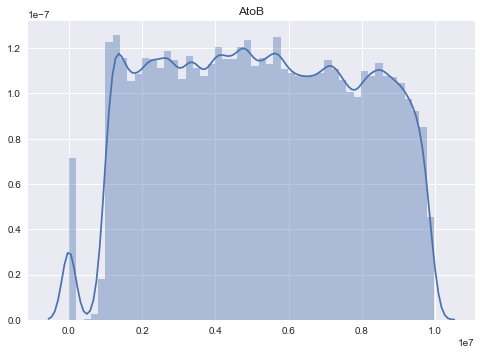

HMGS


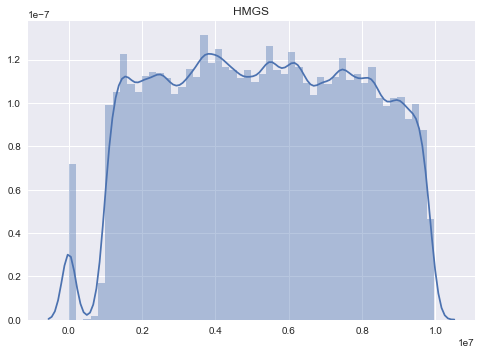

HMGR


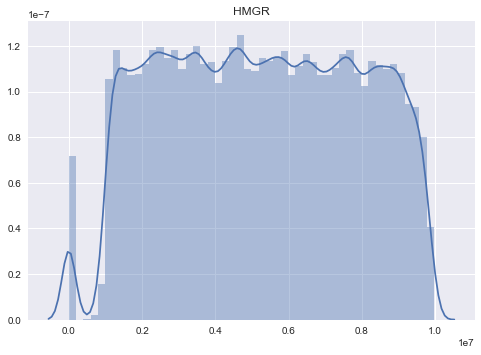

MK


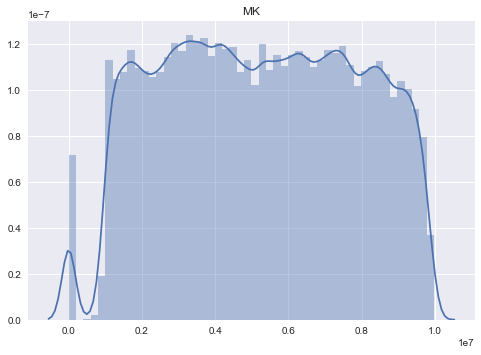

PMK


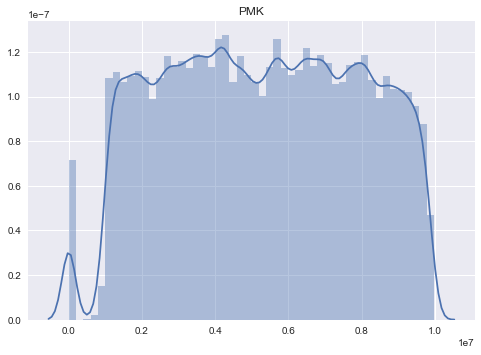

PMD


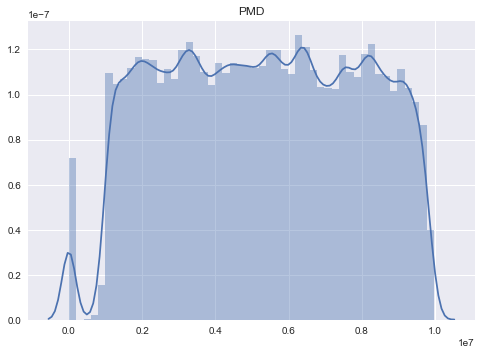

Idi


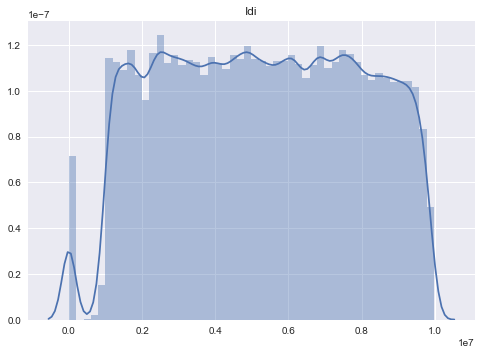

GPPS


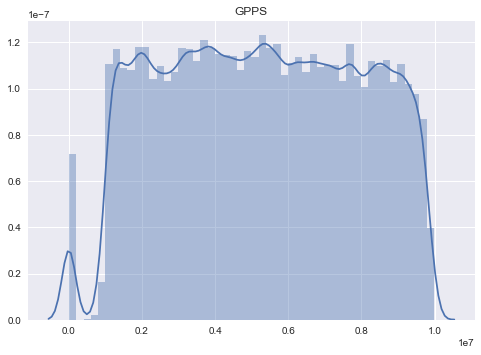

LS


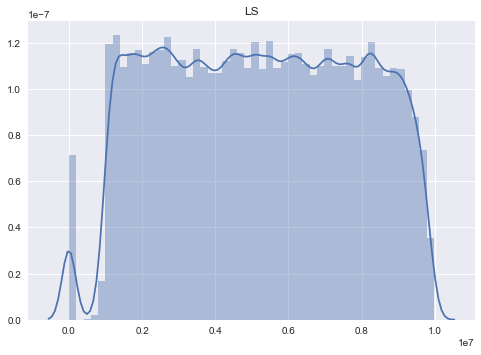

Acetyl-CoA


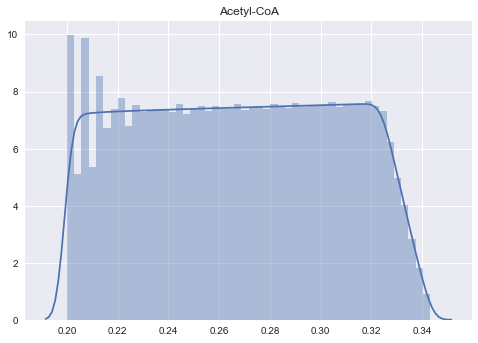

Acetoacetyl-CoA


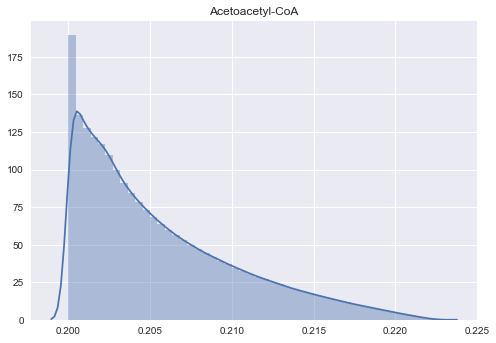

HMG-CoA


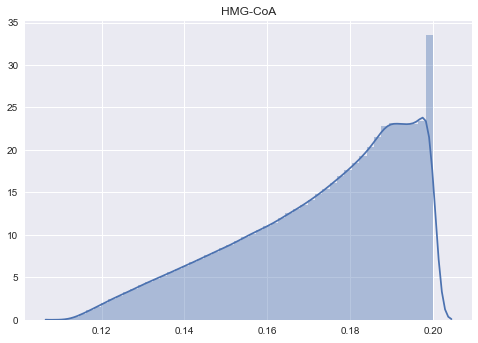

Mev


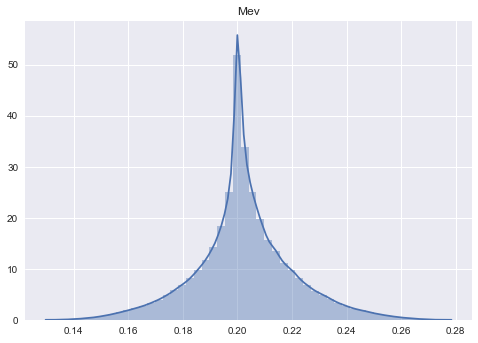

MevP


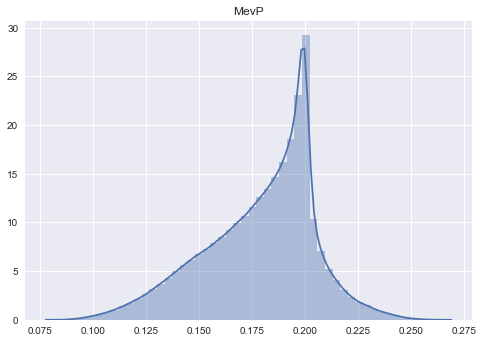

MevPP


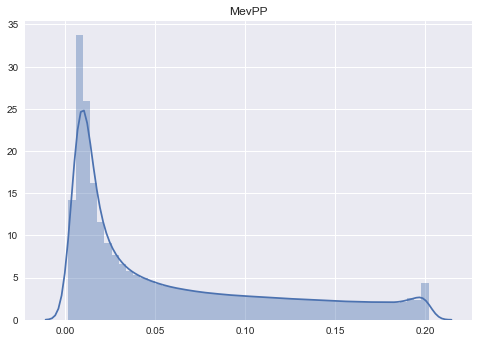

IPP


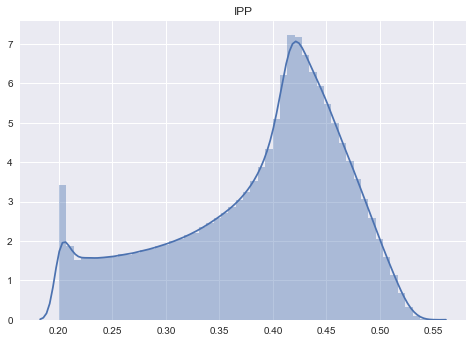

DMAPP


/Users/zakcostello/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


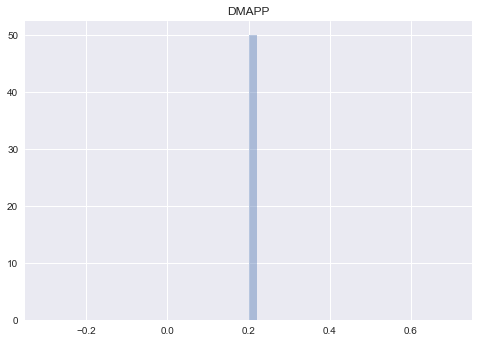

GPP


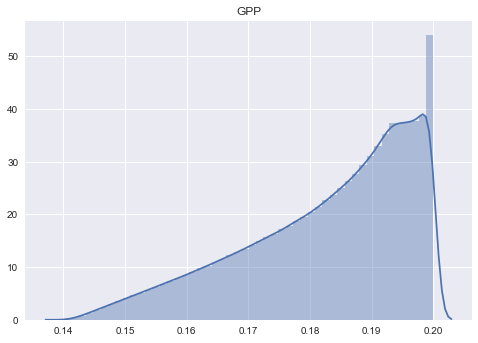

Limonene


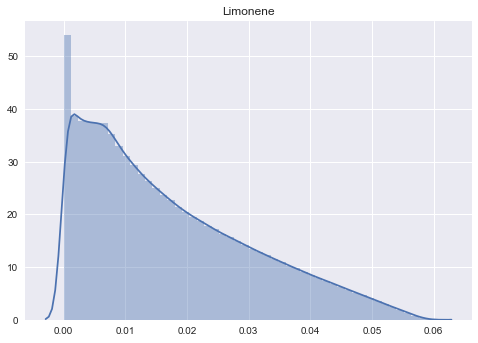

Index(['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'Idi', 'GPPS', 'LS',
       'Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP',
       'IPP', 'DMAPP', 'GPP', 'Limonene'],
      dtype='object')


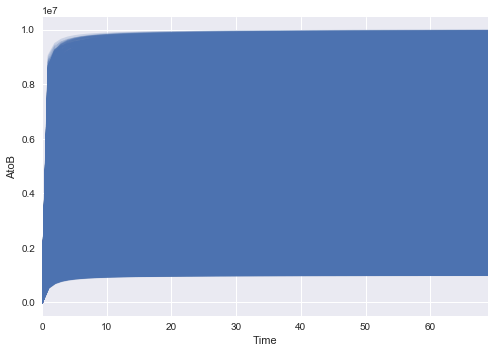

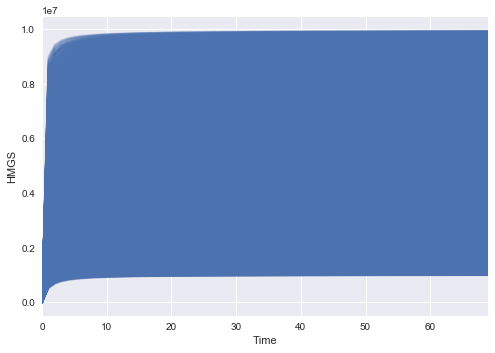

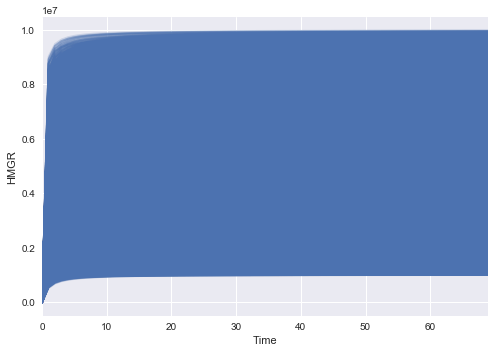

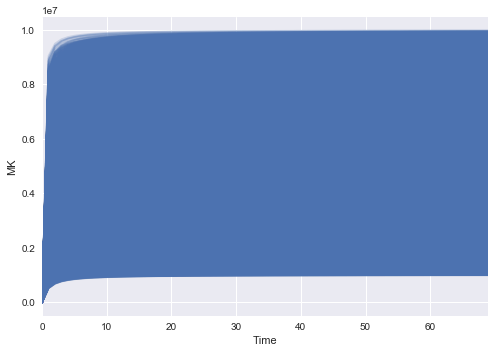

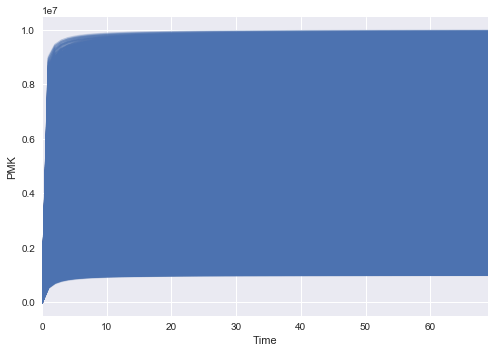

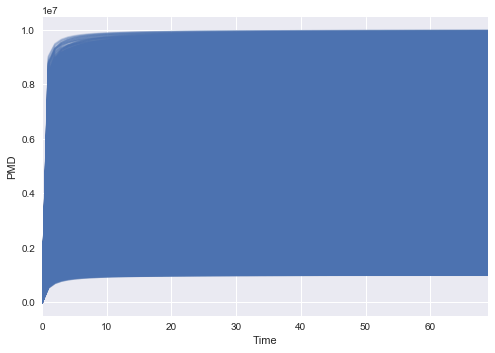

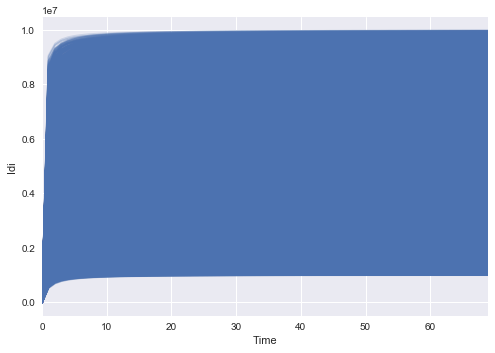

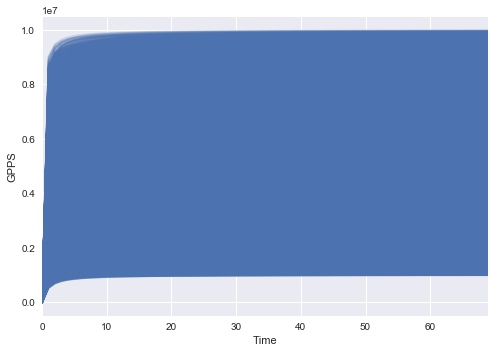

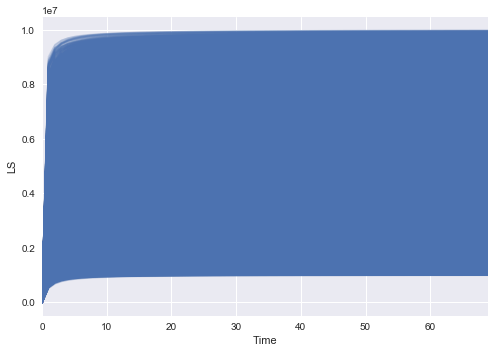

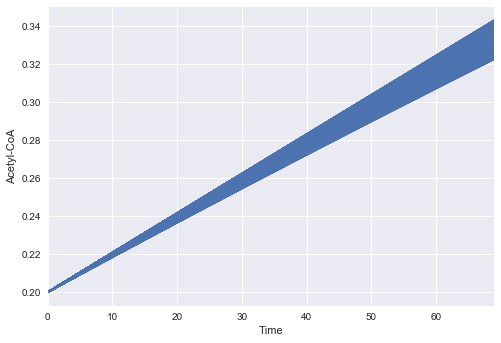

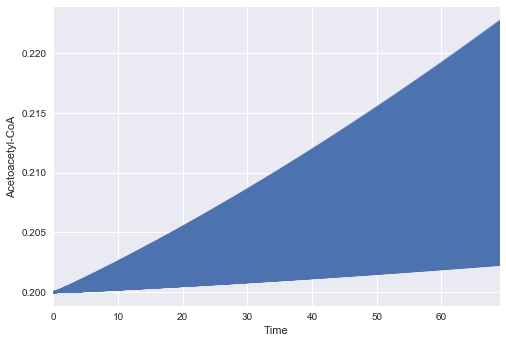

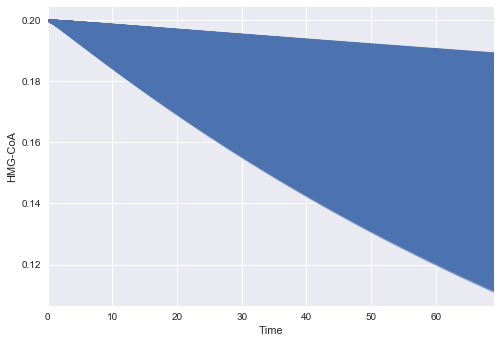

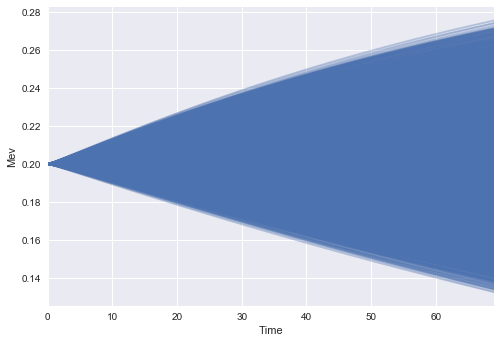

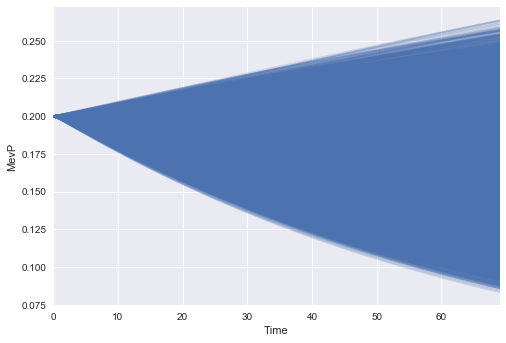

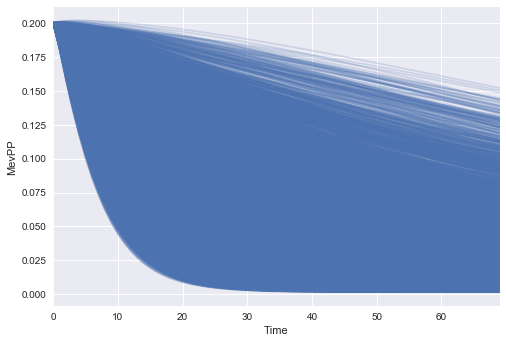

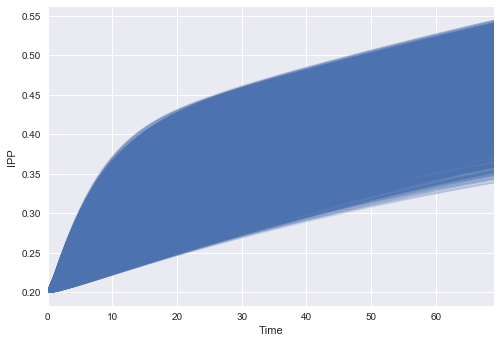

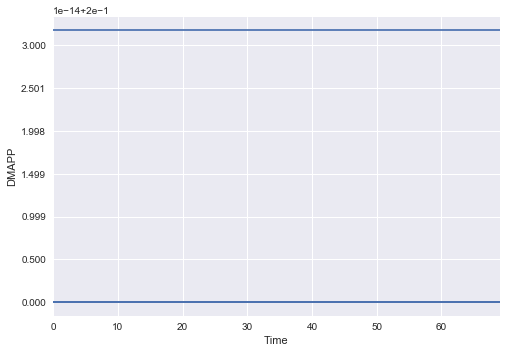

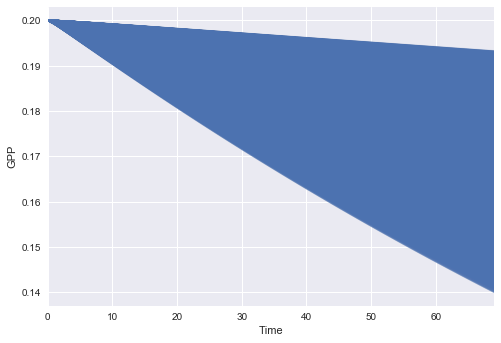

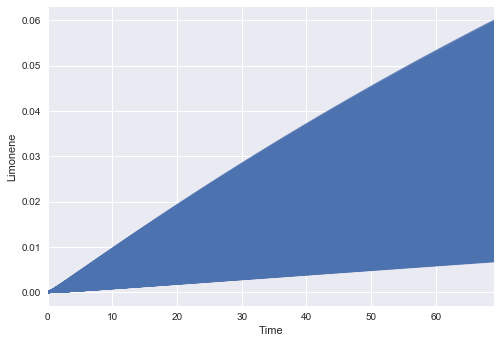

In [13]:
#Plot Distributions for each Metabolite...
df = pd.DataFrame(CSV[1:],columns=CSV[0])

#Generate Column Wise Dist Plots (With Legend...)
column = lambda table,i: [entry[i] for entry in table[1:]]
for i in range(2,len(CSV[1])):
    print(df.columns[i])
    try:
        sns.distplot(column(CSV,i))
        plt.title(CSV[0][i])
        plt.show()
    except:
        pass
    

#Generate Trace Plots
unique_strains = list(set(df['Strain'].values))
species = df.columns[2:]
print(species)
for element in species:
    #display(df[['Time','Strain',element]])
    sns.tsplot(df,time='Time',unit='Strain',value=element,err_style='unit_traces')
    plt.show()


## 4. Write out Generated Strains to CSV File

In [14]:
#Print CSV to File
fileName =  kinetic_name + 'd' + str(numStrains) + 'n0.csv'
with open(fileName, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(CSV)